## Detrended Autocorrelation Periodicity Scoring (DAPS)
based on http://www.ctralie.com/Research/p53periodicity/moosmullertralie2020_p53periodicity.pdf

In [1]:
import numpy as np
import gudhi as gd
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
#%matplotlib widget

In [2]:
#autocorrelation function of time series x and delay tau
def acf(x, tau):
    N = len(x)
    numerator = np.sum([(x[i]-np.mean(x))*(x[i+tau]-np.mean(x)) for i in range(1,N-tau)])
    denominator = np.sum([(x[i]-np.mean(x))**2 for i in range(1,N)])
    return numerator/denominator

def pitch_score(x):
    vals = np.array([acf(x, tau) for tau in range(0,len(x))])
    return np.max(vals[vals!=1])

def detrend_timeseries(x, M):
    N=len(x)
    tde = TimeDelayEmbedding(dim = M, delay=1, skip=1)
    Xhat = tde.transform(x)
    Xhat = Xhat-np.mean(Xhat,1)[:, None]
    Xhat = Xhat/np.sqrt(np.sum(Xhat**2, 1))[:, None]
    Y = np.zeros_like(Xhat)
    for i in range(0,len(Xhat)):
        for j in range(0,len(Xhat[i])):
            #ar1=np.array(range(1-i,M-i+1))
            #ar2 = np.array(range(-N+M-1+j,j-1))
            #print(i,j, np.intersect1d(ar1,ar2))
            Y[i][j] =np.mean([Xhat[i+k][j-k] for k in range(0,max(len(Xhat),len(Xhat[i]))) if 1 <= i+k and i+k <= M and 1 <= j-k and j-k <= N-M+1 ])
    y = np.zeros(Y.shape[0]+Y.shape[1]-1)
    for i in range(0, Y.shape[0]):
        y[i] = Y[0][i]
    for i in range(1, Y.shape[1]):
        y[Y.shape[0]-1+i] = Y[i][-1]
    return y

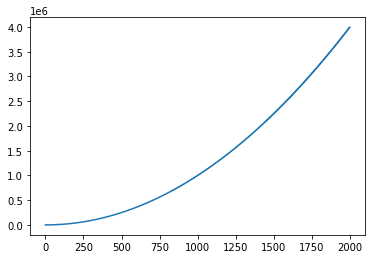

0.9984364649402533


IndexError: tuple index out of range

In [15]:
N = 2000
x = np.array([i*(i+(-1)**(i)) for i in range(0,N)])
f,ax = plt.subplots()
ax.plot(range(0,N), x)
plt.show()
print(pitch_score(x))

y = detrend_timeseries(x, 2)
f,ax = plt.subplots()
ax.plot(range(0,N), y)
plt.show()
print(pitch_score(y))
#tau =1
#N=50
#i=1
#[(x[i]-np.mean(x))*(x[i+tau]-np.mean(x)) for i in range(1,N-tau+1)]

In [14]:
tde = TimeDelayEmbedding(1,1,1)
tde.transform(x)

IndexError: tuple index out of range

In [2]:
datapath =".\\data\\timeseries\\good2"
filelist = os.listdir(datapath)
print(sorted(filelist))
good_labels  =sorted(filelist)
good_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]
datapath =".\\data\\timeseries\\bad2"
filelist = os.listdir(datapath)
print(sorted(filelist))
bad_labels = sorted(filelist)
bad_time_series = [np.loadtxt(os.path.join(datapath,f)) for f in sorted(filelist)]

print(good_time_series[0])

['signal05_good.txt', 'signal10_good.txt', 'signal15_good.txt', 'signal20_good.txt', 'signal25_good.txt']
['signal05_bad.txt', 'signal10_bad.txt', 'signal15_bad.txt', 'signal20_bad.txt', 'signal25_bad.txt']
[ 0.2504463   0.07998543 -0.35629045 ... -0.55235447 -0.22336272
 -0.37701057]


In [3]:
dim = 1041
delay = 1
skip = 1
N=len(good_time_series[0])
M=dim

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
good_point_clouds = tde.transform(good_time_series)
bad_point_clouds = tde.transform(bad_time_series)
for i in range(0,len(good_point_clouds)):
    good_point_clouds[i] = good_point_clouds[i]-np.mean(good_point_clouds[i],1)[:, None]
    good_point_clouds[i] = good_point_clouds[i]/np.sqrt(np.sum(good_point_clouds[i]**2, 1))[:, None]
    bad_point_clouds[i] = bad_point_clouds[i]-np.mean(bad_point_clouds[i],1)[:, None]
    bad_point_clouds[i] = bad_point_clouds[i]/np.sqrt(np.sum(good_point_clouds[i]**2, 1))[:, None]

In [5]:
#This takes forever to run

Ys = []

for Xhat in good_point_clouds+bad_point_clouds:
    Y = np.zeros_like(Xhat)
    for i in range(0,len(Xhat)):
        for j in range(0,len(Xhat[i])):
            #ar1=np.array(range(1-i,M-i+1))
            #ar2 = np.array(range(-N+M-1+j,j-1))
            #print(i,j, np.intersect1d(ar1,ar2))
            Y[i][j] =np.mean([Xhat[i+k][j-k] for k in range(0,max(len(Xhat),len(Xhat[i]))) if 1 <= i+k and i+k <= M and 1 <= j-k and j-k <= N-M+1 ])

    Ys.append(Y)

C:\Users\Niklas\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Niklas\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
detrended_time_series = []
for Y in Ys:
    x = np.zeros(Y.shape[0]+Y.shape[1]-1)
    for i in range(0, Y.shape[0]):
        x[i] = Y[0][i]
    for i in range(1, Y.shape[1]):
        x[Y.shape[0]-1+i] = Y[i][-1]
    detrended_time_series.append(x)
    